# **Objetivo**

El objetivo de este proyecto es desarrollar un **sistema de Inteligencia Artificial basado en redes neuronales convolucionales (CNN)** de **identificar y clasificar imágenes de comida y no comida** de forma precisa y escalable.

El sistema se construye siguiendo una **arquitectura en cascada**, donde distintos modelos especializados se encargan de resolver cada etapa del problema.

<br>

## Clasificación binaria (Food vs No-Food)

Este módulo entrena un primer modelo encargado de determinar si una imagen contiene **comida** o **no comida**, actuando como filtro inicial del sistema.

**Qué hace**

1. Analiza la imagen de entrada.

2. Predice si pertenece a la categoría food o no_food.

3. Decide qué modelo especializado debe ejecutarse a continuación.

**Ventajas**

* Reduce errores en la clasificación final.

* Evita clasificar imágenes no relacionadas como comida.

* Mejora la robustez del sistema en entornos reales.

<br>

## Clasificación de alimentos (121 clases)

Si la imagen es clasificada como food, se aplica un segundo modelo entrenado para reconocer **121 tipos distintos de alimentos**, utilizando el dataset **Food-101 **(adaptado y ampliado).

**Qué hace**

1. Recibe únicamente imágenes previamente clasificadas como comida.

2. Predice la clase concreta del alimento.

3. Devuelve una probabilidad asociada a cada clase.

**Aplicaciones**

* Identificación precisa del tipo de alimento.

* Asociación con información nutricional (calorías, macronutrientes, etc.).

* Sistemas de control dietético y recomendación alimentaria.

<br>

## Clasificación de no-alimentos (22 clases)

Si la imagen es clasificada como `no_food`, se utiliza un modelo específico entrenado para identificar **22 categorías diferentes de no comida.**

**Clases incluidas**

* Personas

* Animales

* Basura

* Objetos cotidianos

* Paisajes

* Vehículos, entre otros

**Objetivo**

* No solo descartar imágenes de comida, sino comprender el contexto visual general de la imagen.

<br>

## Evaluación y métricas

El rendimiento del sistema se evalúa utilizando métricas estándar en visión por computador.

**Métricas utilizadas**

* Top-1 Accuracy

* Top-3 Accuracy

* Top-5 Accuracy

* Precision, Recall y F1-score por clase

* Matrices de confusión (globales y por subconjuntos de clases)

Estas métricas permiten evaluar tanto el rendimiento global como el comportamiento por clase.

<br>

## Resultado final

El resultado es un sistema **modular, reutilizable y extensible** que puede integrarse en:

* Aplicaciones móviles

* Plataformas de análisis de imágenes

* Sistemas de recomendación nutricional

* Servicios automáticos de clasificación visual

## Instalación de dependencias

Hay que instalar las librerías necesarias para entrenamiento e inferencia y ejecutar esta celda en una celda de notebook o en una terminal.

**Paquetes principales**
- `timm==0.9.2` —> modelos EfficientNet y otros.
- `torchmetrics`, `albumentations==1.3.0`, `opencv-python-headless` —> utilidades para métricas y aumentos.
- `scikit-learn` —> utilidades (split, métricas).
- `fastai==1.0.61` —> opcional

> Nota: usar GPU para entrenamiento; en Colab el runtime debe ser GPU para su correcto funcionamiento.


In [ ]:
# Ejecutar en una celda de terminal o notebook con !
!pip install -q timm==0.9.2 torchmetrics albumentations==1.3.0 opencv-python-headless
# opcional para fastai approach
!pip install -q fastai==1.0.61

!pip install -q scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 48.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 8.0 MB/s eta 0:00:00


## Montar Google Drive y copiar dataset

Esta celda monta Google Drive y valida la estructura del dataset `Food-101`. Explica lo que hace el script:

**Qué hace**
1. Monta Drive en `/content/drive`.
2. Define rutas: `DRIVE_DATA_DIR = "/content/drive/MyDrive/Food-101"` y `LOCAL_DATA_DIR = "/content/Food-101"`.
3. `dataset_ok(base)` verifica que existan `train` y `val` y un número razonable de clases.
4. Si el dataset es válido en Drive y no existe en local, lo copia a `/content` (más rápido para entrenamiento en Colab).

**Recomendaciones**
- Copiar a disco local (`copytree`) es recomendable en Colab para evitar I/O lento sobre Drive.
- Si la comprobación falla, revisa que las carpetas `train` y `val` estén correctamente estructuradas.


In [1]:

# Monta Google Drive en el entorno de Google Colab lo que nos da velocidad a la hora de entrenar al copiar los archivos a Google Collab
from google.colab import drive
drive.mount('/content/drive')

import os
import shutil

# Ruta donde está el dataset en Google Drive
DRIVE_DATA_DIR = "/content/drive/MyDrive/Food-101"

# Ruta donde se copiará el dataset al disco local de Colab.
LOCAL_DATA_DIR = "/content/Food-101"

def dataset_ok(base):
    """
    Verifica que el dataset tenga la estructura esperada:
    - Carpetas 'train' y 'val'
    - Cada una con un número suficiente de clases (≈ 101 en Food-101)
    """
    for split in ["train", "val"]:
        # Ruta a la partición (train o val)
        p = os.path.join(base, split)
        # Si no existe la carpeta, el dataset no es válido
        if not os.path.exists(p):
            return False

        # Obtiene todas las carpetas de clases dentro del split
        classes = [
            d for d in os.listdir(p)
            if os.path.isdir(os.path.join(p, d))
        ]

        # Food-101 tiene 101 clases, se permite un pequeño margen
        if len(classes) < 90:
            return False

    return True

print(" Comprobando dataset en Drive...")

# Verifica que el dataset en Google Drive sea válido
if not dataset_ok(DRIVE_DATA_DIR):
    raise RuntimeError(" Dataset no válido en Drive")

print(" Dataset OK en Drive")

# Si el dataset no existe en el disco local de Colab, se copia
# Esto mejora mucho la velocidad de lectura durante el entrenamiento
if not os.path.exists(LOCAL_DATA_DIR):
    print(" Copiando Food-101 a disco local (/content)...")
    shutil.copytree(DRIVE_DATA_DIR, LOCAL_DATA_DIR)
    print(" Copia finalizada")
else:
    print(" Dataset ya existe en local")

print(" Validando copia local...")

# Se vuelve a verificar el dataset ya copiado
if not dataset_ok(LOCAL_DATA_DIR):
    raise RuntimeError(" Dataset inválido en local")

print(" Dataset OK en local")

# Variable final que se usará en el entrenamiento
print(" DATA_DIR =", LOCAL_DATA_DIR)





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Comprobando dataset en Drive...
 Dataset OK en Drive
 Copiando Food-101 a disco local (/content)...
 Copia finalizada
 Validando copia local...
 Dataset OK en local
 DATA_DIR = /content/Food-101


## Comprobar disponibilidad de GPU

Comandos para comprobar la GPU y la disponibilidad de CUDA desde Python.

- `!nvidia-smi` muestra la GPU del entorno (o no hace nada si no hay GPU).
- `torch.cuda.is_available()` comprueba desde PyTorch.
- Si hay GPU, imprime el nombre del dispositivo.

**Nota**: importante ejecutar esto antes de iniciar el entrenamiento para confirmar que el entorno está configurado correctamente.


In [ ]:
# en una celda de notebook
!nvidia-smi || true


import torch
print("cuda_available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("device:", torch.cuda.get_device_name(0))



Tue Jan 13 13:01:19 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Script de entrenamiento (`train.py`) — descripción y uso

**Resumen**
Script de entrenamiento robusto que soporta varios modos (ej.: `binary`, `food`, `nofood`). Implementa datasets personalizados, aumentos con Albumentations, training loop con AMP (autocast + GradScaler), muestreo balanceado y guardado de checkpoints.

**Uso (línea de comandos)**
```bash
python train.py --mode binary --data_dir /path/to/data --no_food_dir /path/to/no_food --model_dir /path/to/models --epochs 12 --bs 16 --img_size 192


In [ ]:
#!/usr/bin/env python3
# train.py — Multi-mode: binary | food | nofood
# DEBUG VERSION (robusta y clara)

"""
train.py — Entrenamiento de modelos sobre Food-101

Soporta modos: 'binary' (food vs no-food) y 'food' (clasificación multi-clase).
Usa timm, albumentations y entrenamiento con AMP.

Ejemplo:
  python train.py --mode binary --data_dir /content/Food-101 --no_food_dir /content/drive/MyDrive/no_food --model_dir ./models --epochs 12
"""


import os, argparse, time
import numpy as np
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torch.utils.data import WeightedRandomSampler


from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast

import timm
from torch.optim import AdamW

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm
from collections import Counter

# ======================================================
# DATASETS
# ======================================================
class AlbumentationsImageFolder(Dataset):
    def __init__(self, root_dir, transform, img_size):
        self.root_dir = root_dir
        self.transform = transform
        self.img_size = img_size
        self.samples = []

        classes = sorted(d for d in os.listdir(root_dir)
                         if os.path.isdir(os.path.join(root_dir, d)))

        if len(classes) == 0:
            raise RuntimeError(f"No classes found in {root_dir}")

        self.class_to_idx = {c:i for i,c in enumerate(classes)}
        self.classes = classes

        for c in classes:
            cdir = os.path.join(root_dir, c)
            for f in os.listdir(cdir):
                self.samples.append((os.path.join(cdir, f), self.class_to_idx[c]))

        if len(self.samples) == 0:
            raise RuntimeError(f"No images found in {root_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        p,y = self.samples[idx]
        try:
            img = np.array(Image.open(p).convert("RGB"))
        except Exception:
            img = np.zeros((self.img_size, self.img_size, 3), np.uint8)
        img = self.transform(image=img)["image"]
        return img, y


class BinaryFoodNoFoodDataset(Dataset):
    def __init__(self, food_root, transform, img_size,
                 no_food_dir=None, split="train",
                 val_ratio=0.2, seed=42):

        self.transform = transform
        self.img_size = img_size
        self.samples = []

        # FOOD
        for cls in os.listdir(food_root):
            cls_dir = os.path.join(food_root, cls)
            if not os.path.isdir(cls_dir):
                continue
            for f in os.listdir(cls_dir):
                self.samples.append((os.path.join(cls_dir, f), 0))

        # NO FOOD
        if no_food_dir:
            nf_files = []
            for root, _, files in os.walk(no_food_dir):
                for f in files:
                    if f.lower().endswith((".jpg",".png",".jpeg")):
                        nf_files.append(os.path.join(root, f))

            if len(nf_files) > 0:
                tr_nf, va_nf = train_test_split(
                    nf_files,
                    test_size=val_ratio,
                    random_state=seed,
                    shuffle=True
                )
                use_files = tr_nf if split == "train" else va_nf
                for p in use_files:
                    self.samples.append((p, 1))

        self.classes = ["food", "no_food"]

        if len(self.samples) == 0:
            raise RuntimeError("Binary dataset is empty")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        p, y = self.samples[idx]
        try:
            img = np.array(Image.open(p).convert("RGB"))
        except Exception:
            img = np.zeros((self.img_size, self.img_size, 3), np.uint8)
        img = self.transform(image=img)["image"]
        return img, y

# ======================================================
# TRANSFORMS
# ======================================================
def get_transforms(sz):
    size = (sz, sz)

    train_t = A.Compose([
        A.RandomResizedCrop(size=size, scale=(0.7, 1.0)),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(0.2, 0.2, 0.2, 0.02, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    val_t = A.Compose([
        A.Resize(height=sz, width=sz),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    return train_t, val_t

# ======================================================
# TRAIN / EVAL
# ======================================================
def train_epoch(model, loader, opt, scaler, dev, crit, epoch, log_every):
    model.train()
    total_loss = 0
    seen = 0
    start = time.time()

    print(f"🟡 Epoch {epoch} | {len(loader)} batches")

    for i,(x,y) in enumerate(loader):
        x,y = x.to(dev), y.to(dev)
        opt.zero_grad(set_to_none=True)

        with autocast():
            out = model(x)
            loss = crit(out,y)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        total_loss += loss.item() * x.size(0)
        seen += x.size(0)

        if i % log_every == 0:
            print(f"   batch {i}/{len(loader)} | loss {loss.item():.4f}")

    avg = total_loss / seen
    print(f"🟢 Epoch {epoch} done | avg train loss {avg:.4f} | {time.time()-start:.1f}s")
    return avg

def eval_model(model, loader, dev):
    model.eval()
    ok = tot = 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(dev), y.to(dev)
            p = model(x).argmax(1)
            ok += (p==y).sum().item()
            tot += y.size(0)
    return ok / tot

# ======================================================
# MAIN
# ======================================================
# ------------------ PEGAR/REEMPLAZAR main() POR ESTE BLOQUE ------------------
import shutil
import sys

def parse_args_robust():
    ap = argparse.ArgumentParser()
    ap.add_argument("--mode", required=True)
    ap.add_argument("--data_dir")
    ap.add_argument("--no_food_dir")
    ap.add_argument("--model_dir", default="./models")
    ap.add_argument("--epochs", type=int, default=12)
    ap.add_argument("--bs", type=int, default=16)
    ap.add_argument("--img_size", type=int, default=192)
    ap.add_argument("--workers", type=int, default=2)
    ap.add_argument("--log_every", type=int, default=200)
    ap.add_argument("--copy_to_tmp", action="store_true",
                    help="Copiar dataset a /tmp para evitar lentitud de Google Drive (recomendado).")
    ap.add_argument("--save_every_epoch", type=int, default=1,
                    help="Guardar checkpoint cada N épocas.")
    # Si ejecutas desde bash con args funcionará como antes.
    # Si ejecutas dentro de IPython/Colab y no pasas args, evitamos SystemExit y devolvemos None.
    try:
        args = ap.parse_args()
    except SystemExit:
        # Estamos en entorno interactivo sin args: devolver None para que el entorno (shell) decida.
        print(" argparse: falta --mode o estás en entorno interactivo. Usa la ejecución por línea de comandos (%%bash) o pasa args explícitos.", flush=True)
        raise
    return args

def main():
    args = parse_args_robust()

    # Si pides copiar a tmp (recomendado en Colab cuando tu dataset está en Drive)
    if args.copy_to_tmp and args.data_dir:
        tmp_dest = f"/tmp/food_dataset_{int(time.time())}"
        if os.path.exists(tmp_dest):
            print("🗑 Limpiando tmp anterior...", flush=True)
            shutil.rmtree(tmp_dest)
        print(f"Copiando datos desde {args.data_dir} -> {tmp_dest} (esto puede tardar unos minutos)...", flush=True)
        shutil.copytree(args.data_dir, tmp_dest)
        args.data_dir = tmp_dest
        print("Copia completada.", flush=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"DEVICE: {device}", flush=True)

    tr_t, va_t = get_transforms(args.img_size)

    if args.mode == "food":
        tr_ds = AlbumentationsImageFolder(os.path.join(args.data_dir,"train"), tr_t, args.img_size)
        va_ds = AlbumentationsImageFolder(os.path.join(args.data_dir,"val"), va_t, args.img_size)
        classes = tr_ds.classes
        with open(os.path.join(args.model_dir, f"classes_{args.mode}.txt"), "w") as f:
            f.write("\n".join(classes))
    elif args.mode == "binary":
        tr_ds = BinaryFoodNoFoodDataset(os.path.join(args.data_dir,"train"), tr_t, args.img_size, args.no_food_dir,"train")
        va_ds = BinaryFoodNoFoodDataset(os.path.join(args.data_dir,"val"), va_t, args.img_size, args.no_food_dir,"val")
        classes = ["food","no_food"]
    else:
        raise ValueError("Modo no soportado")

    print(f"Train samples: {len(tr_ds)}", flush=True)
    print(f"Val samples:   {len(va_ds)}", flush=True)
    print(f"Classes: {len(classes)}", flush=True)

    counts = Counter(y for _,y in tr_ds.samples)
    print("Class distribution:", counts, flush=True)

    sample_weights = [1.0 / counts[y] for _, y in tr_ds.samples]
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    # Si estás leyendo desde Drive, para debug pon workers=0 (evita deadlocks)
    workers = args.workers
    if 'google.colab' in sys.modules:
        print("Detectado Colab: si tienes problemas con DataLoader prueba --workers 0", flush=True)

    tr_dl = DataLoader(
        tr_ds,
        batch_size=args.bs,
        sampler=sampler,
        num_workers=workers,
        pin_memory=(device.type == "cuda"),
        persistent_workers=False
    )
    va_dl = DataLoader(va_ds, args.bs, shuffle=False,
                       num_workers=workers, pin_memory=(device.type == "cuda"))

    model = timm.create_model("efficientnet_b0", pretrained=True,
                              num_classes=len(classes)).to(device)

    opt = AdamW(model.parameters(), lr=3e-4)
    scaler = GradScaler()
    crit = nn.CrossEntropyLoss(label_smoothing=0.1)

    best = 0
    os.makedirs(args.model_dir, exist_ok=True)

    try:
        for e in range(1, args.epochs+1):
            # log inicial por epoch
            print(f"\n=== 🔸 Época {e}/{args.epochs} ===", flush=True)
            print(f"🟡 Epoch {e} | {len(tr_dl)} batches (bs={args.bs})", flush=True)
            train_epoch(model, tr_dl, opt, scaler, device, crit, e, args.log_every)
            acc = eval_model(model, va_dl, device)
            print(f"📈 VAL ACC = {acc:.4f}", flush=True)

            # guardado por epochs según parámetro
            if e % args.save_every_epoch == 0:
                ckpt = {
                    "epoch": e,
                    "state_dict": model.state_dict(),
                    "optimizer": opt.state_dict(),
                    "scaler": scaler.state_dict(),
                    "acc": acc
                }
                path = os.path.join(args.model_dir, f"checkpoint_epoch{e}_{args.mode}.pth")
                torch.save(ckpt, path)
                print(f"💾 Checkpoint guardado: {path}", flush=True)

            if acc > best:
                best = acc
                torch.save(model.state_dict(),
                           os.path.join(args.model_dir, f"best_{args.mode}.pth"))
                print("NEW BEST MODEL SAVED", flush=True)

    except Exception as exc:
        # guardar checkpoint parcial y reportar excepción
        print("Excepción durante el entrenamiento, guardando checkpoint parcial...", flush=True)
        try:
            torch.save({
                "state_dict": model.state_dict(),
                "optimizer": opt.state_dict(),
                "scaler": scaler.state_dict(),
                "exception": str(exc)
            }, os.path.join(args.model_dir, f"crash_partial_{args.mode}.pth"))
            print("Checkpoint parcial guardado.", flush=True)
        except Exception as e2:
            print("No se pudo guardar checkpoint parcial:", e2, flush=True)
        raise

    print("-> Finished | Best acc:", best, flush=True)

# ---------------------------------------------------------------------------





# **EJECUCIÓN DEL TRAIN EN 3 CAPAS**





# Celda 5 — Ejecutar entrenamiento (modo `binary`)
```markdown
## Ejecutar entrenamiento — modo `binary` (ejemplo)

Este bloque crea variables de entorno y ejecuta `train.py` para el modo `binary`.

- `LOCAL_DATA_PATH`: dataset copiado localmente (`/content/Food-101`).
- `NO_FOOD_DIR`: carpeta con imágenes no-food en Drive (sin split).
- `MODEL_DIR`: carpeta de salida en Drive (para guardar checkpoints y logs).

```
**Consejo**
- Ajusta `--bs`, `--img_size`, `--epochs` según la GPU.
- Usa `--copy_to_tmp` si tu dataset está aún en Drive y quieres copiarlo a `/tmp` para mejor I/O.

<BR>

## Entrenamiento modo `food` (fases)

Comando que entrena la clasificación multi-clase (Food-101) posiblemente en dos fases:
- `--phase both` y parámetros `--epochs_phase1`, `--epochs_phase2` (si tu script lo soporta).

**Notas**
- Comprueba que `train.py` implemente la lógica de fases (`phase`, `epochs_phase1`, `epochs_phase2`).
- Guardar checkpoints en Drive permite reanudar o descargar los mejores modelos.

<BR>

## Entrenamiento modo `nofood`

Similar a los anteriores: ejecuta `train.py` en un modo orientado a entrenar un clasificador que trate sólo clases de "no food" o un modelo especializado.

**Atención**
- Asegúrate de que `--mode nofood` esté implementado en `train.py`.




In [ ]:
%%bash
LOCAL_DATA_PATH="/content/Food-101"
NO_FOOD_DIR="/content/drive/MyDrive/no_food"   # carpeta ORIGINAL, sin split
MODEL_DIR="/content/drive/MyDrive/Food-101/models"

mkdir -p "$MODEL_DIR"

python /content/Food-101/train.py \
  --mode binary \
  --data_dir "$LOCAL_DATA_PATH" \
  --no_food_dir "$NO_FOOD_DIR" \
  --model_dir "$MODEL_DIR" \
  --epochs 6 \
  --bs 32 \
  --img_size 192 \
  --workers 2


Modo: BINARY (food vs no_food)

Epoch 1/6
val acc = 0.9806
✅ saved /content/drive/MyDrive/Food-101/models/best_binary.pth

Epoch 2/6
val acc = 0.9730

Epoch 3/6
val acc = 0.9799

Epoch 4/6
val acc = 0.9868
✅ saved /content/drive/MyDrive/Food-101/models/best_binary.pth

Epoch 5/6
val acc = 0.9626

Epoch 6/6
val acc = 0.9880
✅ saved /content/drive/MyDrive/Food-101/models/best_binary.pth
Finished. Best acc: 0.9880016988744956
Classes file at: /content/drive/MyDrive/Food-101/models/classes_binary.txt


/content/Food-101/train.py:233: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/2552 [00:00<?, ?it/s]/content/Food-101/train.py:140: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 43%|████▎     | 1096/2552 [07:12<15:58,  1.52it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 92%|█████████▏| 541/589 [01:58<01:06,  1.39s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 69%|██████▉   | 1773/2552 [10:21<05:28,  2.37it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transpar

In [ ]:
%%bash
python train.py \
  --mode food \
  --data_dir "/content/Food-101" \
  --model_dir "/content/drive/MyDrive/Food-101/models" \
  --phase both \
  --epochs_phase1 10 \
  --epochs_phase2 20 \
  --bs 16 \
  --img_size 192 \
  --save_ckpt_to_drive

🚀 DEVICE: cuda
📦 Train samples: 72949
📦 Val samples:   15147
🧠 Classes: 122
📊 Class distribution: Counter({1: 700, 2: 700, 3: 700, 4: 700, 5: 700, 6: 700, 7: 700, 8: 700, 10: 700, 11: 700, 12: 700, 14: 700, 16: 700, 17: 700, 19: 700, 20: 700, 21: 700, 22: 700, 23: 700, 24: 700, 25: 700, 26: 700, 27: 700, 30: 700, 31: 700, 35: 700, 36: 700, 37: 700, 38: 700, 39: 700, 40: 700, 42: 700, 43: 700, 45: 700, 47: 700, 48: 700, 49: 700, 50: 700, 51: 700, 52: 700, 53: 700, 54: 700, 55: 700, 57: 700, 58: 700, 60: 700, 61: 700, 62: 700, 63: 700, 64: 700, 65: 700, 67: 700, 68: 700, 69: 700, 70: 700, 71: 700, 75: 700, 77: 700, 78: 700, 79: 700, 80: 700, 81: 700, 82: 700, 83: 700, 85: 700, 86: 700, 87: 700, 89: 700, 90: 700, 92: 700, 94: 700, 95: 700, 96: 700, 98: 700, 100: 700, 101: 700, 102: 700, 103: 700, 105: 700, 106: 700, 107: 700, 108: 700, 109: 700, 110: 700, 111: 700, 112: 700, 113: 700, 114: 700, 115: 700, 116: 700, 117: 700, 118: 700, 120: 700, 121: 700, 29: 699, 41: 699, 66: 699, 84: 699,

/content/train.py:395: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/content/train.py:164: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/skl

CalledProcessError: Command 'b'python train.py \\\n  --mode food \\\n  --data_dir "/content/Food-101" \\\n  --model_dir "/content/drive/MyDrive/Food-101/models" \\\n  --phase both \\\n  --epochs_phase1 10 \\\n  --epochs_phase2 20 \\\n  --bs 16 \\\n  --img_size 192 \\\n  --save_ckpt_to_drive\n'' returned non-zero exit status 1.

In [ ]:
%%bash
NO_FOOD_DIR="/content/drive/MyDrive/no_food"
MODEL_DIR="/content/drive/MyDrive/Food-101/models"

python /content/drive/MyDrive/Food-101/train.py \
  --mode nofood \
  --no_food_dir "$NO_FOOD_DIR" \
  --model_dir "$MODEL_DIR" \
  --epochs 12 \
  --bs 16 \
  --img_size 192 \
  --workers 2



Modo: NOFOOD (tipos dentro de no-food)

Epoch 1/12
val acc = 0.8189
✅ saved /content/drive/MyDrive/Food-101/models/best_nofood.pth

Epoch 2/12
val acc = 0.8825
✅ saved /content/drive/MyDrive/Food-101/models/best_nofood.pth

Epoch 3/12
val acc = 0.9110
✅ saved /content/drive/MyDrive/Food-101/models/best_nofood.pth

Epoch 4/12
val acc = 0.9346
✅ saved /content/drive/MyDrive/Food-101/models/best_nofood.pth

Epoch 5/12
val acc = 0.9419
✅ saved /content/drive/MyDrive/Food-101/models/best_nofood.pth

Epoch 6/12
val acc = 0.9477
✅ saved /content/drive/MyDrive/Food-101/models/best_nofood.pth

Epoch 7/12
val acc = 0.9427

Epoch 8/12
val acc = 0.9491
✅ saved /content/drive/MyDrive/Food-101/models/best_nofood.pth

Epoch 9/12
val acc = 0.9601
✅ saved /content/drive/MyDrive/Food-101/models/best_nofood.pth

Epoch 10/12
val acc = 0.9560

Epoch 11/12
val acc = 0.9598

Epoch 12/12
val acc = 0.9566
Finished. Best acc: 0.9600734725444702
Classes file at: /content/drive/MyDrive/Food-101/models/classes_nof

/content/drive/MyDrive/Food-101/train.py:248: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/647 [00:00<?, ?it/s]/content/drive/MyDrive/Food-101/train.py:140: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
 58%|█████▊    | 374/647 [45:01<31:24,  6.90s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 78%|███████▊  | 503/647 [1:00:19<16:08,  6.73s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 19%|█▊        | 120/647 [01:47<09:01,  1.03s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Pal

# **VALIDACIÓN DEL TRAIN**

## Inferencia rápida con el clasificador binario

Script de ejemplo que:
1. Carga `CLASSES_BIN` desde `classes_binary.txt`.
2. Crea el modelo `efficientnet_b0` con `timm` y carga pesos (`best_binary.pth`).
3. Define transform y función `predict(path)` que devuelve la etiqueta, probabilidad y vector de probabilidades.

**Uso**
- Actualiza `MODEL_DIR` y nombres de checkpoint (`BIN_CKPT`) según tu árbol de ficheros.
- Prueba con algunos ejemplos (3 food / 3 no-food) para verificar resultados.

**Salida**
- Para cada imagen imprime: `filename -> predicted_class probability [all_probs...]`.


In [ ]:
import torch, timm, os
from PIL import Image
from torchvision import transforms
import numpy as np

MODEL_DIR = "/content/drive/MyDrive/Food-101/models"
BIN_CKPT = os.path.join(MODEL_DIR, "best_binary.pth")
CLASSES_BIN = os.path.join(MODEL_DIR, "classes_binary.txt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# Cargar clases
with open(CLASSES_BIN, "r") as f:
    classes_bin = [l.strip() for l in f if l.strip()]
print("Loaded binary classes:", classes_bin)

# crear modelo y cargar pesos
m = timm.create_model("efficientnet_b0", pretrained=False, num_classes=len(classes_bin))
sd = torch.load(BIN_CKPT, map_location="cpu")
# quitar posible prefijo module.
new = { (k[len("module."): ] if k.startswith("module.") else k): v for k,v in sd.items() }
m.load_state_dict(new, strict=False)
m.to(device).eval()

# transform
IMG_SIZE = 192
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])

# toma unas imágenes de prueba (3 de food val y 3 de no-food)
food_examples = []
val_food_dir = "/content/Food-101/val"
for root, dirs, files in os.walk(val_food_dir):
    if files:
        for fn in files[:3]:
            food_examples.append(os.path.join(root, fn))
    if len(food_examples) >= 3:
        break

nofood_examples = []
no_food_dir = "/content/drive/MyDrive/no_food"
# toma 3 imágenes de distintas subcarpetas
cnt = 0
for sub in sorted(os.listdir(no_food_dir)):
    sp = os.path.join(no_food_dir, sub)
    if os.path.isdir(sp):
        fs = [f for f in os.listdir(sp) if f.lower().endswith((".jpg",".png",".jpeg"))]
        if fs:
            nofood_examples.append(os.path.join(sp, fs[0]))
            cnt += 1
    if cnt >= 3:
        break

print("Food examples:", food_examples)
print("No-food examples:", nofood_examples)

def predict(path):
    img = Image.open(path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = m(x)
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        p = int(out.argmax(1).cpu().numpy()[0])
    return classes_bin[p], float(probs[p]), probs

print("\n--- PREDICTIONS FOOD EXAMPLES ---")
for p in food_examples:
    cls, prob, probs = predict(p)
    print(os.path.basename(p), "->", cls, prob, "all_probs:", probs.tolist())

print("\n--- PREDICTIONS NO-FOOD EXAMPLES ---")
for p in nofood_examples:
    cls, prob, probs = predict(p)
    print(os.path.basename(p), "->", cls, prob, "all_probs:", probs.tolist())


device: cuda
Loaded binary classes: ['food', 'no_food']
Food examples: []
No-food examples: ['/content/drive/MyDrive/no_food/animals/animals_373_1a3b8cb8.jpeg', '/content/drive/MyDrive/no_food/beaches/beaches_397_43fd4aa9.jpg', '/content/drive/MyDrive/no_food/bottles/bottles_286_6d2ac56a.jpg']

--- PREDICTIONS FOOD EXAMPLES ---

--- PREDICTIONS NO-FOOD EXAMPLES ---
animals_373_1a3b8cb8.jpeg -> no_food 0.9988183379173279 all_probs: [0.001181635307148099, 0.9988183379173279]
beaches_397_43fd4aa9.jpg -> no_food 0.9825178980827332 all_probs: [0.017482107505202293, 0.9825178980827332]
bottles_286_6d2ac56a.jpg -> no_food 0.9988580942153931 all_probs: [0.0011419359361752868, 0.9988580942153931]


## Comprobar GPU, logs y ficheros de models

Comandos útiles:
- `nvidia-smi` — comprobar GPU.
- `tail -n 80 /content/drive/.../train.log` — ver últimas líneas del log de entrenamiento.
- `ls -la /content/drive/.../models` — ver checkpoints guardados.

Incluye en la entrega una captura o listado con los checkpoints y el log más relevante.


In [ ]:
%%bash
# comprueba GPU
nvidia-smi || true

# ver últimas líneas del log
tail -n 80 /content/drive/MyDrive/Food-101/models/train.log || true

# ver checkpoint guardado
ls -la /content/drive/MyDrive/Food-101/models || true


Mon Jan 12 12:25:40 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             31W /   70W |     188MiB /  15360MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Verificación: existencia de carpetas importantes

La celda imprime si `/content/Food-101` y la subcarpeta `val` existen, y muestra los primeros ficheros de `val`.

**Por qué incluirlo**
- Esto demuestra en el notebook que el dataset está correctamente ubicado antes de entrenar.


In [3]:
import os
print("VERIFICACIÓN:")
print("/content/Food-101/ existe:", os.path.exists("/content/Food-101"))
print("/content/Food-101/val existe:", os.path.exists("/content/Food-101/val"))
print("Contenido val:", os.listdir("/content/Food-101/val")[:5] if os.path.exists("/content/Food-101/val") else "NO")


VERIFICACIÓN:
/content/Food-101/ existe: True
/content/Food-101/val existe: True
Contenido val: ['apple_pie', 'chicken_quesadilla', 'huevos_rancheros', 'strawberry_shortcake', 'macaroni_and_cheese']


## Exploración rápida de la estructura del dataset

Comandos:
- `!ls -la /content/Food-101`
- `!find /content/Food-101 -maxdepth 3 -type d | head -n 50`
- Código Python para localizar `train`, `val`, `test`.

**Objetivo**
- Mostrar que la estructura es `root/train/<class>/*`, `root/val/<class>/*` (requisito del dataset Food-101 para este script).


In [2]:
!ls -la /content/Food-101
!find /content/Food-101 -maxdepth 3 -type d | head -n 50

import os

for root, dirs, files in os.walk("/content/Food-101"):
    if 'val' in dirs:
        print("✅ VAL encontrada en:", os.path.join(root, 'val'))
    if 'train' in dirs:
        print("✅ TRAIN encontrada en:", os.path.join(root, 'train'))
    if 'test' in dirs:
        print("✅ TEST encontrada en:", os.path.join(root, 'test'))

total 44
drwx------   7 root root  4096 Jan  5 09:45 .
drwxr-xr-x   1 root root  4096 Jan 18 17:28 ..
drwx------   2 root root  4096 Jan  5 13:09 .ipynb_checkpoints
drwx------   3 root root  4096 Jan  5 13:35 models
drwx------ 123 root root  4096 Jan  5 09:45 test
drwx------ 124 root root  4096 Jan  5 09:45 train
-rw-------   1 root root 12564 Jan 14 10:51 train.py
drwx------ 103 root root  4096 Jan  5 09:45 val
/content/Food-101
/content/Food-101/train
/content/Food-101/train/apple_pie
/content/Food-101/train/chicken_quesadilla
/content/Food-101/train/huevos_rancheros
/content/Food-101/train/strawberry_shortcake
/content/Food-101/train/macaroni_and_cheese
/content/Food-101/train/onion_rings
/content/Food-101/train/gyoza
/content/Food-101/train/pulled_pork_sandwich
/content/Food-101/train/nachos
/content/Food-101/train/red_velvet_cake
/content/Food-101/train/macarons
/content/Food-101/train/bocadillo
/content/Food-101/train/scallops
/content/Food-101/train/albondigas
/content/Food-101/

## Limpiar checkpoint y guardar modelo sin classifier antiguo

Explicación:
- Se cargan `classes.txt` y el checkpoint (`best_efficientnet_b0.pth`).
- Se crea la arquitectura `efficientnet_b0` con `num_classes` = len(classes).
- Se limpia el `state_dict` del checkpoint eliminando claves de `classifier.` y prefijos `module.`.
- Esto permite reutilizar pesos de la backbone aunque el clasificador del checkpoint antiguo tenga otra forma.
- Finalmente se guarda un nuevo estado con `model.state_dict()`.

**Motivo**
- Útil cuando el checkpoint proviene de un entrenamiento con un `classifier` distinto (por ejemplo, 1000 clases -> 122 clases).


In [ ]:
import torch, timm, os
from collections import OrderedDict

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CLASSES_PATH = "/content/drive/MyDrive/Food-101/models/classes.txt"
MODEL_PATH   = "/content/drive/MyDrive/Food-101/models/best_efficientnet_b0.pth"

# 1 Clases
with open(CLASSES_PATH) as f:
    classes = [l.strip() for l in f if l.strip()]
num_classes = len(classes)
print("Loaded classes:", num_classes)

# 2️ Modelo
model = timm.create_model(
    "efficientnet_b0",
    pretrained=False,
    num_classes=num_classes
).to(DEVICE)

# 3️ Cargar checkpoint
ckpt = torch.load(MODEL_PATH, map_location="cpu")
state_dict = ckpt if isinstance(ckpt, dict) else ckpt.state_dict()

# 4️ LIMPIAR classifier del checkpoint (CLAVE)
clean = OrderedDict()
for k, v in state_dict.items():
    k = k.replace("module.", "")
    if k.startswith("classifier."):
        continue   # ⬅️ ELIMINAMOS classifier viejo
    clean[k] = v

# 5️ Cargar pesos
missing, unexpected = model.load_state_dict(clean, strict=False)
model.eval()

print("✅ Modelo cargado SIN classifier antiguo")
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

# 6️ Guardar modelo listo
OUT_PATH = "/content/drive/MyDrive/Food-101/models/best_efficientnet_b0_122cls.pth"
torch.save(model.state_dict(), OUT_PATH)
print("💾 Guardado en:", OUT_PATH)



Loaded classes: 122
✅ Modelo cargado SIN classifier antiguo
Missing keys: ['classifier.weight', 'classifier.bias']
Unexpected keys: []
💾 Guardado en: /content/drive/MyDrive/Food-101/models/best_efficientnet_b0_122cls.pth


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Inference en cascada (binary → food / nofood)

Descripción:
- `inference_cascade.py` implementa una tubería de inferencia en 2 pasos:
  1. El modelo binario (`best_binary.pth`) decide si la imagen es `food` o `no_food`.
  2. Si es `food`, se consulta `food_model` para clasificar la clase concreta.
     Si no es `food`, se consulta `no_model` para predecir la clase no-food más probable.

**Funciones clave**
- `load_model(ckpt, num_classes)` — carga un modelo desde checkpoint y limpia prefijo `module.`.
- `predict_single(path, bin_thresh=None)`:
  - Si `bin_thresh` es `None` usa argmax binario.
  - Si `bin_thresh` es float interpreta el umbral de probabilidad para la clase `food`.

**Salida**
- Tupla con ( `"food"|"no_food"`, etiqueta_predicha, probabilidad, lista_de_probabilidades ).

**Ejemplo**
```python
print(predict_single("/path/to/image.jpg", bin_thresh=0.5))


In [4]:
# inference_cascade.py
import os, torch, timm, numpy as np
from PIL import Image
from torchvision import transforms

MODEL_DIR = "/content/drive/MyDrive/Food-101/models"
BIN_CKPT = os.path.join(MODEL_DIR, "best_binary.pth")
FOOD_CKPT = os.path.join(MODEL_DIR, "best_food.pth")
NOFOOD_CKPT = os.path.join(MODEL_DIR, "best_nofood.pth")

CLASSES_BIN = [l.strip() for l in open(os.path.join(MODEL_DIR,"classes_binary.txt")) if l.strip()]
CLASSES_FOOD = [l.strip() for l in open(os.path.join(MODEL_DIR,"classes_food.txt")) if l.strip()]
CLASSES_NO = [l.strip() for l in open(os.path.join(MODEL_DIR,"classes_nofood.txt")) if l.strip()]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(ckpt, num_classes):
    m = timm.create_model("efficientnet_b0", pretrained=False, num_classes=num_classes)
    sd = torch.load(ckpt, map_location="cpu")
    sd = { (k[len("module."): ] if k.startswith("module.") else k): v for k,v in sd.items() }
    m.load_state_dict(sd, strict=False)
    return m.to(device).eval()

bin_model = load_model(BIN_CKPT, len(CLASSES_BIN))
food_model = load_model(FOOD_CKPT, len(CLASSES_FOOD))
no_model = load_model(NOFOOD_CKPT, len(CLASSES_NO))

IMG_SIZE = 192
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])

def predict_single(path, bin_thresh=None):
    img = Image.open(path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out_bin = torch.softmax(bin_model(x), dim=1).cpu().numpy()[0]
    # bin prediction
    idx_bin = int(out_bin.argmax())
    if bin_thresh is not None:
        # interpret bin_thresh as probability threshold for "food"
        p_food = out_bin[ CLASSES_BIN.index("food") ]
        is_food = p_food >= bin_thresh
    else:
        is_food = (idx_bin == CLASSES_BIN.index("food"))
    if is_food:
        with torch.no_grad():
            out_food = torch.softmax(food_model(x), dim=1).cpu().numpy()[0]
        pred_idx = int(out_food.argmax())
        return ("food", CLASSES_FOOD[pred_idx], float(out_food[pred_idx]), out_food.tolist())
    else:
        with torch.no_grad():
            out_no = torch.softmax(no_model(x), dim=1).cpu().numpy()[0]
        pred_idx = int(out_no.argmax())
        return ("no_food", CLASSES_NO[pred_idx], float(out_no[pred_idx]), out_no.tolist())

# ejemplo
# print(predict_single("/content/drive/MyDrive/some_image.jpg", bin_thresh=0.5))


# **EVALUACIÓN FINAL**

<BR>

# Evaluación final del modelo

**Propósito**:
**Evaluar** el modelo de clasificación de alimentos entrenado sobre Food-101 usando **exclusivamente las clases reales** del entrenamiento.

<BR>


**Qué hace:**

* Carga **configuración**, **clases** y** modelo entrenado**.

* **Garantiza** que el **número** y **orden** de clases coinciden con el entrenamiento.

* Realiza **inferencia **sobre todo el **conjunto de test**.

* Calcula **métricas Top-1, Top-3 **y **Top-5** Accuracy.

* **Genera** un **classification report detallado**.

- Device: cuda
- Clases reales del modelo: 122
- Modelo cargado correctamente
🎯 Total samples evaluados: 17268
1. Top-1 Accuracy : 0.6896
2. Top-3 Accuracy : 0.8414
3. Top-5 Accuracy : 0.8894

📊 Classification Report:
                         precision    recall  f1-score   support

             albondigas       0.97      0.79      0.87       110
              apple_pie       0.54      0.33      0.41       150
         baby_back_ribs       0.58      0.73      0.65       150
                baklava       0.71      0.69      0.70       150
         beef_carpaccio       0.73      0.73      0.73       150
           beef_tartare       0.87      0.62      0.72       150
             beet_salad       0.57      0.57      0.57       150
               beignets       0.81      0.85      0.83       150
               bibimbap       0.65      0.89      0.75       150
              bocadillo       0.93      0.67      0.78        60
          bread_pudding       0.67      0.27      0.39       150
 

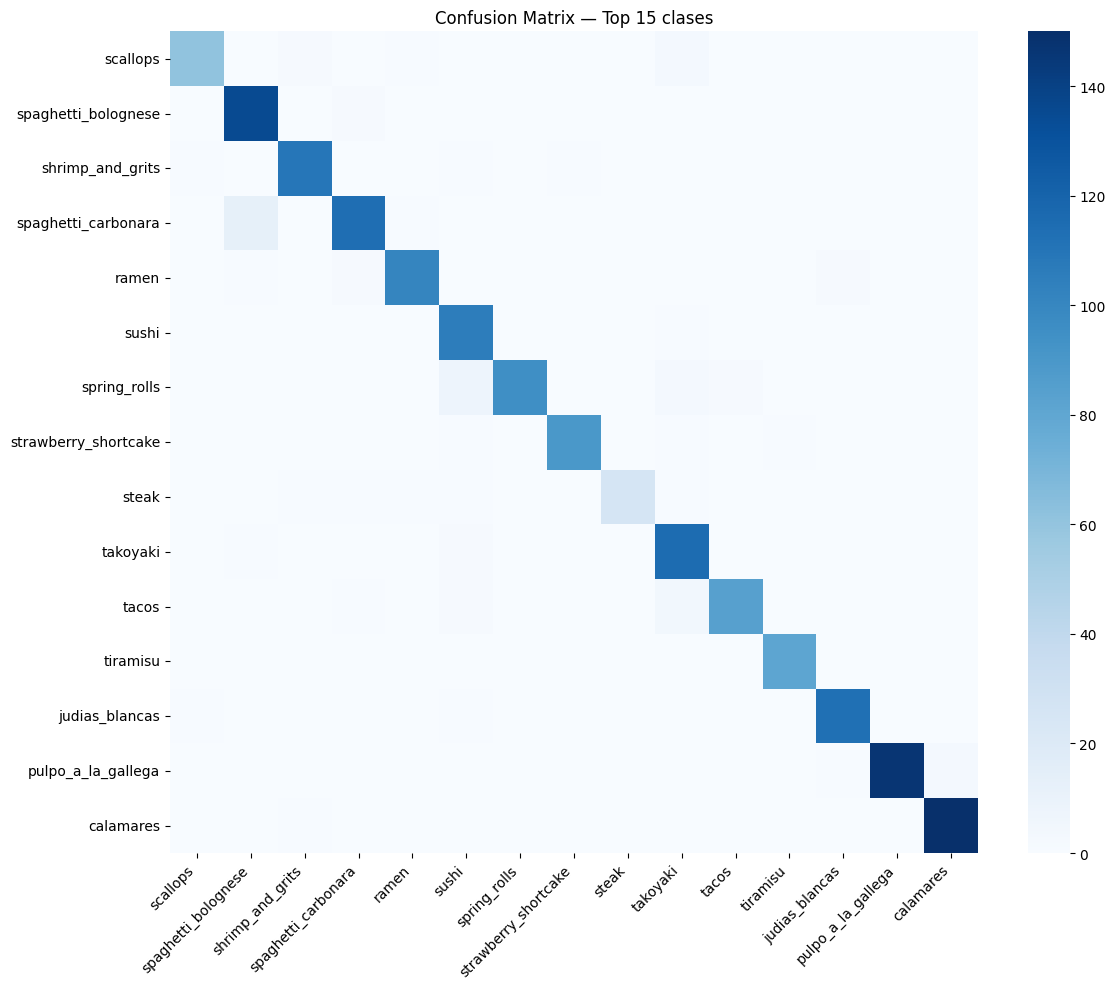

In [ ]:
# =========================================================
# EVALUACIÓN FINAL — Food-101 (CLASES REALES DE ENTRENAMIENTO)
# =========================================================
import os
import torch
import timm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    top_k_accuracy_score
)
import seaborn as sns

# ---------------------------------------------------------
# CONFIGURACIÓN
# ---------------------------------------------------------
TRAIN_DIR = "/content/drive/MyDrive/Food-101/train"
TEST_DIR  = "/content/drive/MyDrive/Food-101/test"
MODEL_PATH = "/content/drive/MyDrive/Food-101/models/best_food.pth"
CLASSES_FILE = "/content/drive/MyDrive/Food-101/models/classes_food.txt"

IMG_SIZE = 192
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("- Device:", DEVICE)

# ---------------------------------------------------------
# CLASES (FUENTE ÚNICA: ENTRENAMIENTO REAL)
# ---------------------------------------------------------
if not os.path.exists(CLASSES_FILE):
    raise FileNotFoundError(f"No existe {CLASSES_FILE}")

with open(CLASSES_FILE, "r") as f:
    classes = [l.strip() for l in f if l.strip()]

NUM_CLASSES = len(classes)
class_to_idx = {c: i for i, c in enumerate(classes)}

print("- Clases reales del modelo:", NUM_CLASSES)

# ---------------------------------------------------------
# MODELO
# ---------------------------------------------------------
ckpt = torch.load(MODEL_PATH, map_location="cpu")

# extraer state_dict correctamente
if isinstance(ckpt, dict) and "state_dict" in ckpt:
    state_dict = ckpt["state_dict"]
else:
    state_dict = ckpt

# limpiar posible prefijo "module."
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

# crear modelo con el MISMO nº de clases
model = timm.create_model(
    "efficientnet_b0",
    pretrained=False,
    num_classes=NUM_CLASSES
)

# cargar pesos COMPLETOS
model.load_state_dict(state_dict, strict=True)
model.to(DEVICE).eval()

print("- Modelo cargado correctamente")

# ---------------------------------------------------------
# TRANSFORMS (idénticos a validación)
# ---------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])

# ---------------------------------------------------------
# PREDICCIÓN
# ---------------------------------------------------------
def predict(img_path):
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        out = model(x)
        probs = torch.softmax(out, dim=1)[0].cpu().numpy()
    return probs

# ---------------------------------------------------------
# EVALUACIÓN COMPLETA
# ---------------------------------------------------------
y_true, y_pred, y_probs = [], [], []

for cls in os.listdir(TEST_DIR):
    if cls not in class_to_idx:
        continue  # ← ignora clases no entrenadas

    gt = class_to_idx[cls]
    cls_path = os.path.join(TEST_DIR, cls)

    for fn in os.listdir(cls_path):
        if not fn.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        path = os.path.join(cls_path, fn)
        try:
            probs = predict(path)
            y_true.append(gt)
            y_pred.append(int(np.argmax(probs)))
            y_probs.append(probs)
        except Exception as e:
            print(" Error:", path, e)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)

print(" Total samples evaluados:", len(y_true))

# ---------------------------------------------------------
# MÉTRICAS
# ---------------------------------------------------------
labels = list(range(NUM_CLASSES))

top1 = accuracy_score(y_true, y_pred)
top3 = top_k_accuracy_score(y_true, y_probs, k=3, labels=labels)
top5 = top_k_accuracy_score(y_true, y_probs, k=5, labels=labels)

print(f"1. Top-1 Accuracy : {top1:.4f}")
print(f"2. Top-3 Accuracy : {top3:.4f}")
print(f"3. Top-5 Accuracy : {top5:.4f}")

print("\n Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=classes,
    zero_division=0
))

# ---------------------------------------------------------
# CONFUSION MATRIX (TOP 15 CLASES MÁS FRECUENTES)
# ---------------------------------------------------------
cm = confusion_matrix(y_true, y_pred)
idx = np.argsort(cm.sum(axis=1))[-15:]

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm[np.ix_(idx, idx)],
    xticklabels=[classes[i] for i in idx],
    yticklabels=[classes[i] for i in idx],
    cmap="Blues",
    annot=False
)
plt.title("Confusion Matrix — Top 15 clases")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



# Creación del dataset de test

**Propósito**:
Crear un dataset PyTorch para trabajar cómodamente con imágenes del conjunto de test.

<BR>

**Qué hace:**

* Usa `ImageFolder` para cargar imágenes y etiquetas automáticamente.

* Aplica las mismas transformaciones usadas en validación.

* **Verifica el número de imágenes** y clases disponibles.

In [ ]:
from torchvision.datasets import ImageFolder

test_dataset = ImageFolder(
    root=TEST_DIR,
    transform=transform
)

print(" test_dataset creado")
print("Nº imágenes:", len(test_dataset))
print("Clases:", len(test_dataset.classes))


✅ test_dataset creado
Nº imágenes: 17268
Clases: 121


# Predicciones aleatorias con imágenes

**Propósito**:
Analizar visualmente el comportamiento del modelo sobre imágenes reales.

<BR>

**Qué hace:**

* Selecciona **imágenes aleatorias** del conjunto de test.

* Ejecuta **inferencia Top-K** sobre cada imagen.

* **Muestra la imagen**, la **etiqueta real **y las predicciones con probabilidades.

* Colorea el título según si la predicción es **correcta** o **incorrecta**.

In [ ]:
import random
import torch
import matplotlib.pyplot as plt
import numpy as np

def mostrar_predicciones_random(
    model, dataset, classes, device,
    n=8, topk=3
):
    model.eval()
    n = min(n, len(dataset))  # seguridad
    idxs = random.sample(range(len(dataset)), n)

    plt.figure(figsize=(16, 8))

    for i, idx in enumerate(idxs):
        img, label = dataset[idx]
        x = img.unsqueeze(0).to(device)

        with torch.no_grad():
            out = model(x)
            probs = torch.softmax(out, dim=1)[0]
            top_probs, top_idxs = probs.topk(topk)

        pred_labels = [classes[j] for j in top_idxs.cpu()]
        pred_probs = top_probs.cpu().numpy()

        ok = top_idxs[0].item() == label
        color = "green" if ok else "red"

        title = f"GT: {classes[label]}\n"
        for p, pr in zip(pred_labels, pred_probs):
            title += f"{p}: {pr:.2f}\n"

        # ---- desnormalizar imagen ----
        img_show = img.permute(1, 2, 0).cpu().numpy()
        img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min())

        plt.subplot(2, (n + 1)//2, i + 1)
        plt.imshow(img_show)
        plt.axis("off")
        plt.title(title, fontsize=9, color=color)

    plt.tight_layout()
    plt.show()



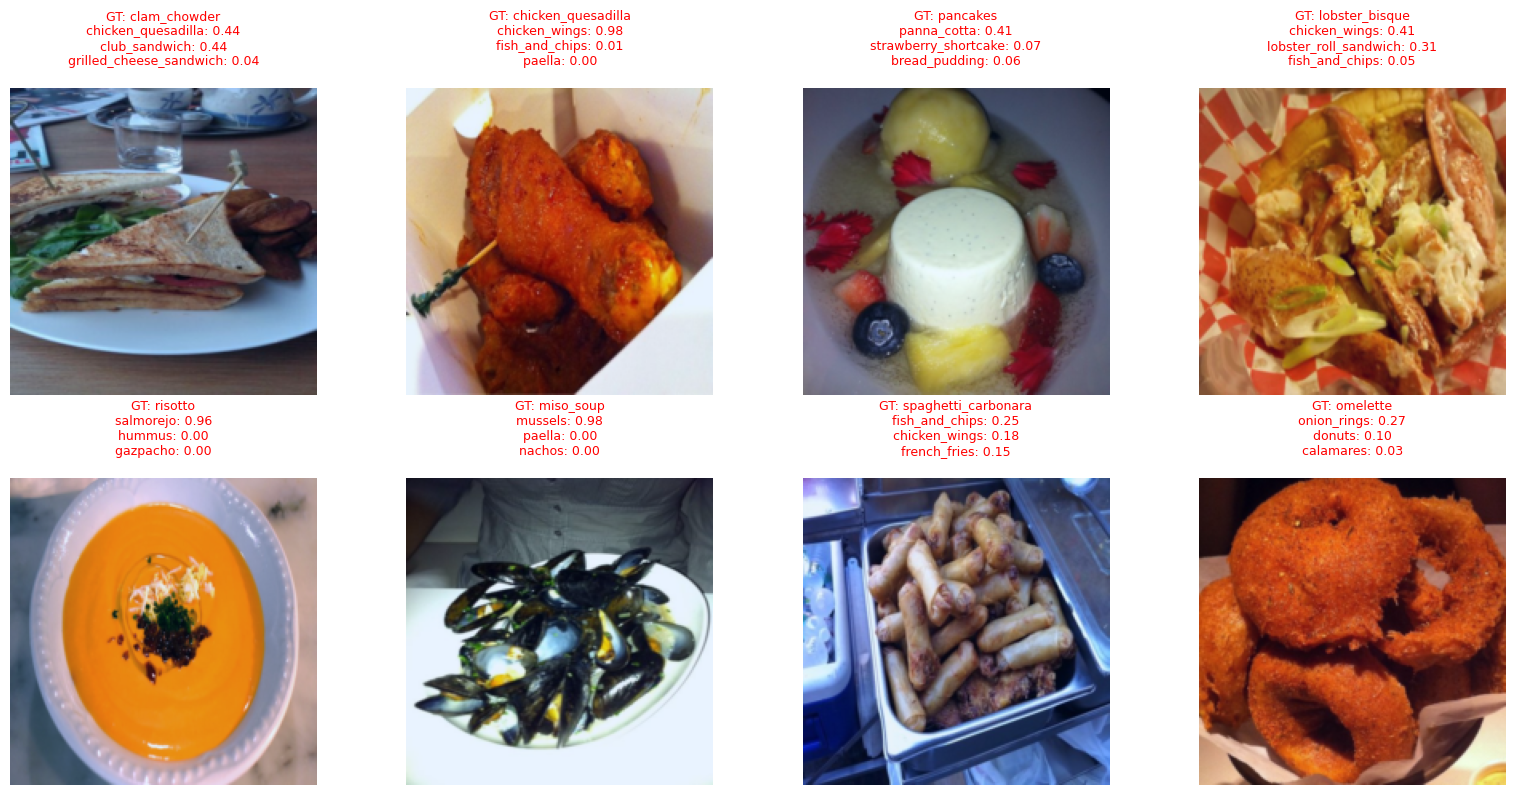

In [ ]:
mostrar_predicciones_random(
    model=model,
    dataset=test_dataset,
    classes=classes,
    device=DEVICE,
    n=8,
    topk=3
)


# Matriz de confusión (Top-N clases)

**Propósito**:
Identificar confusiones frecuentes entre las clases más representadas del dataset.

<BR>

**Qué hace:**

* Calcula la matriz de confusión global.

* Selecciona las clases con mayor número de muestras.

* Normaliza los valores para facilitar la interpretación.

* Muestra un mapa de calor visual.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_top_classes(y_true, y_pred, classes, top_n=30):
    cm = confusion_matrix(y_true, y_pred)
    support = cm.sum(axis=1)

    top_idx = np.argsort(support)[-top_n:]
    cm = cm[top_idx][:, top_idx]
    cls = [classes[i] for i in top_idx]

    cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(14, 12))
    sns.heatmap(
        cm_norm,
        xticklabels=cls,
        yticklabels=cls,
        cmap="viridis",
        annot=False
    )
    plt.title("Confusion Matrix (Top clases)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()



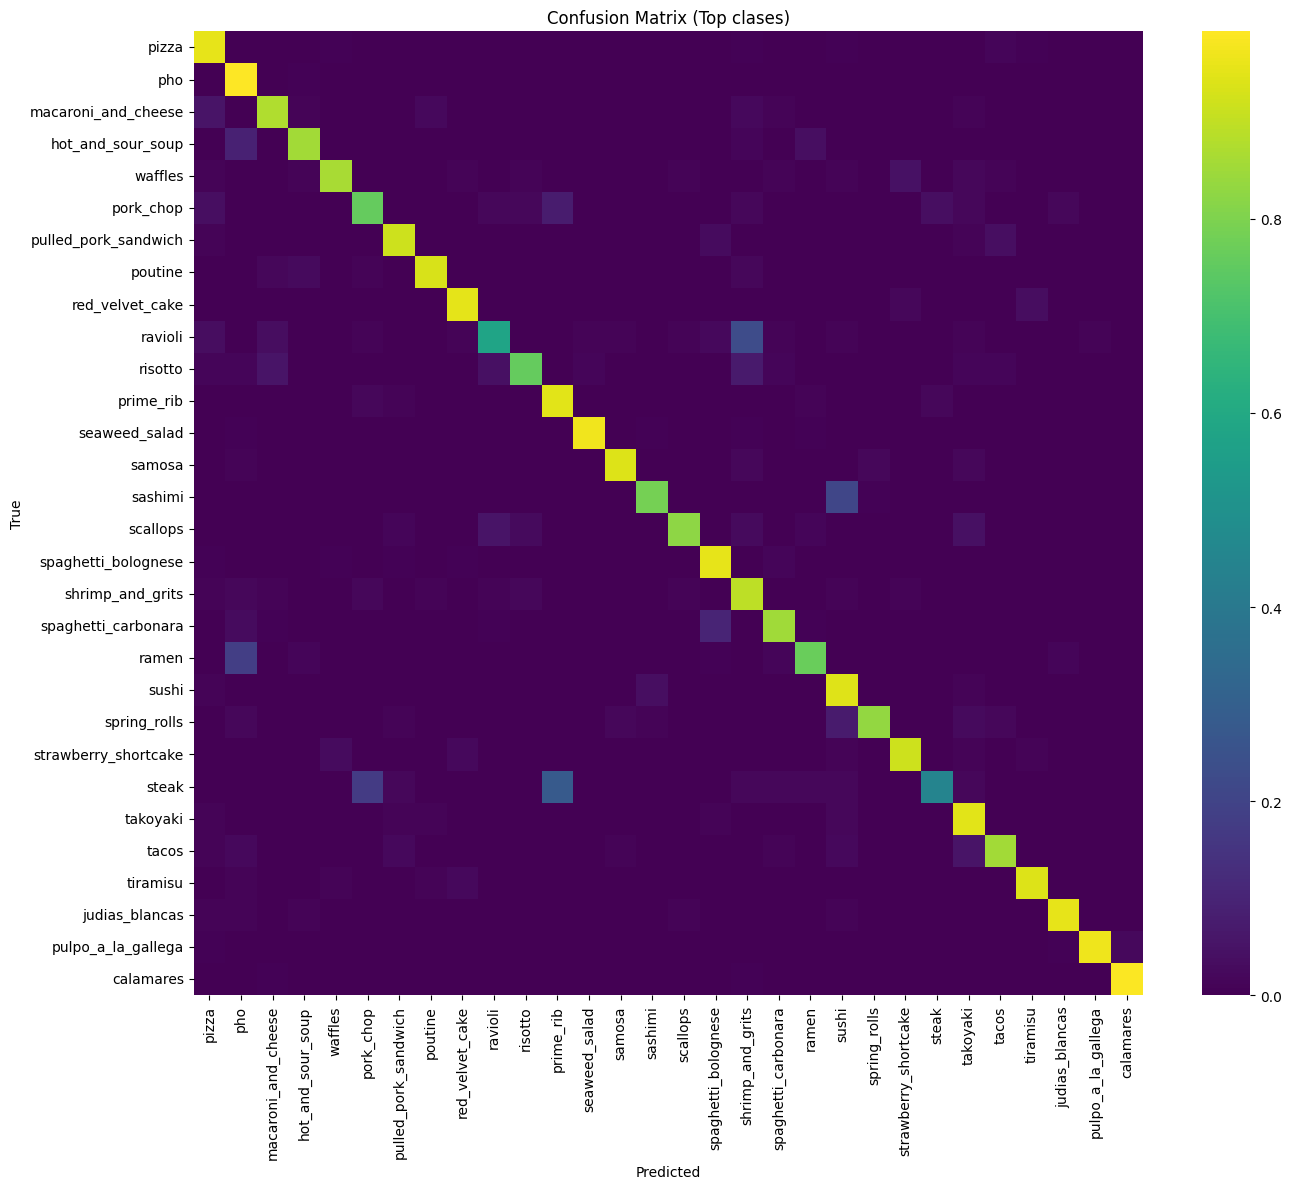

In [ ]:
plot_confusion_top_classes(y_true, y_pred, classes, top_n=30)


# Recall por clase

**Propósito**:
Evaluar qué clases son mejor y peor reconocidas por el modelo.

<BR>

**Qué hace:**

* Genera el classification report en formato diccionario.

* Extrae el recall de cada clase con soporte válido.

* Ordena las clases por rendimiento.

* Muestra un gráfico de barras horizontal.

<BR>

# Resumen general

Estas celdas cubren **evaluación cuantitativa y cualitativa** completa del sistema, permitiendo:

* Medir rendimiento global.

* Analizar errores por clase.

* Visualizar predicciones reales.

* Tomar decisiones informadas para mejoras futuras.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_accuracy_per_class(report):
    df = pd.DataFrame(report).T
    df = df[df["support"] > 0]
    df = df.sort_values("recall")

    plt.figure(figsize=(10, 18))
    plt.barh(df.index, df["recall"])
    plt.xlabel("Recall")
    plt.title("Recall por clase")
    plt.tight_layout()
    plt.show()


✅ report_dict creado


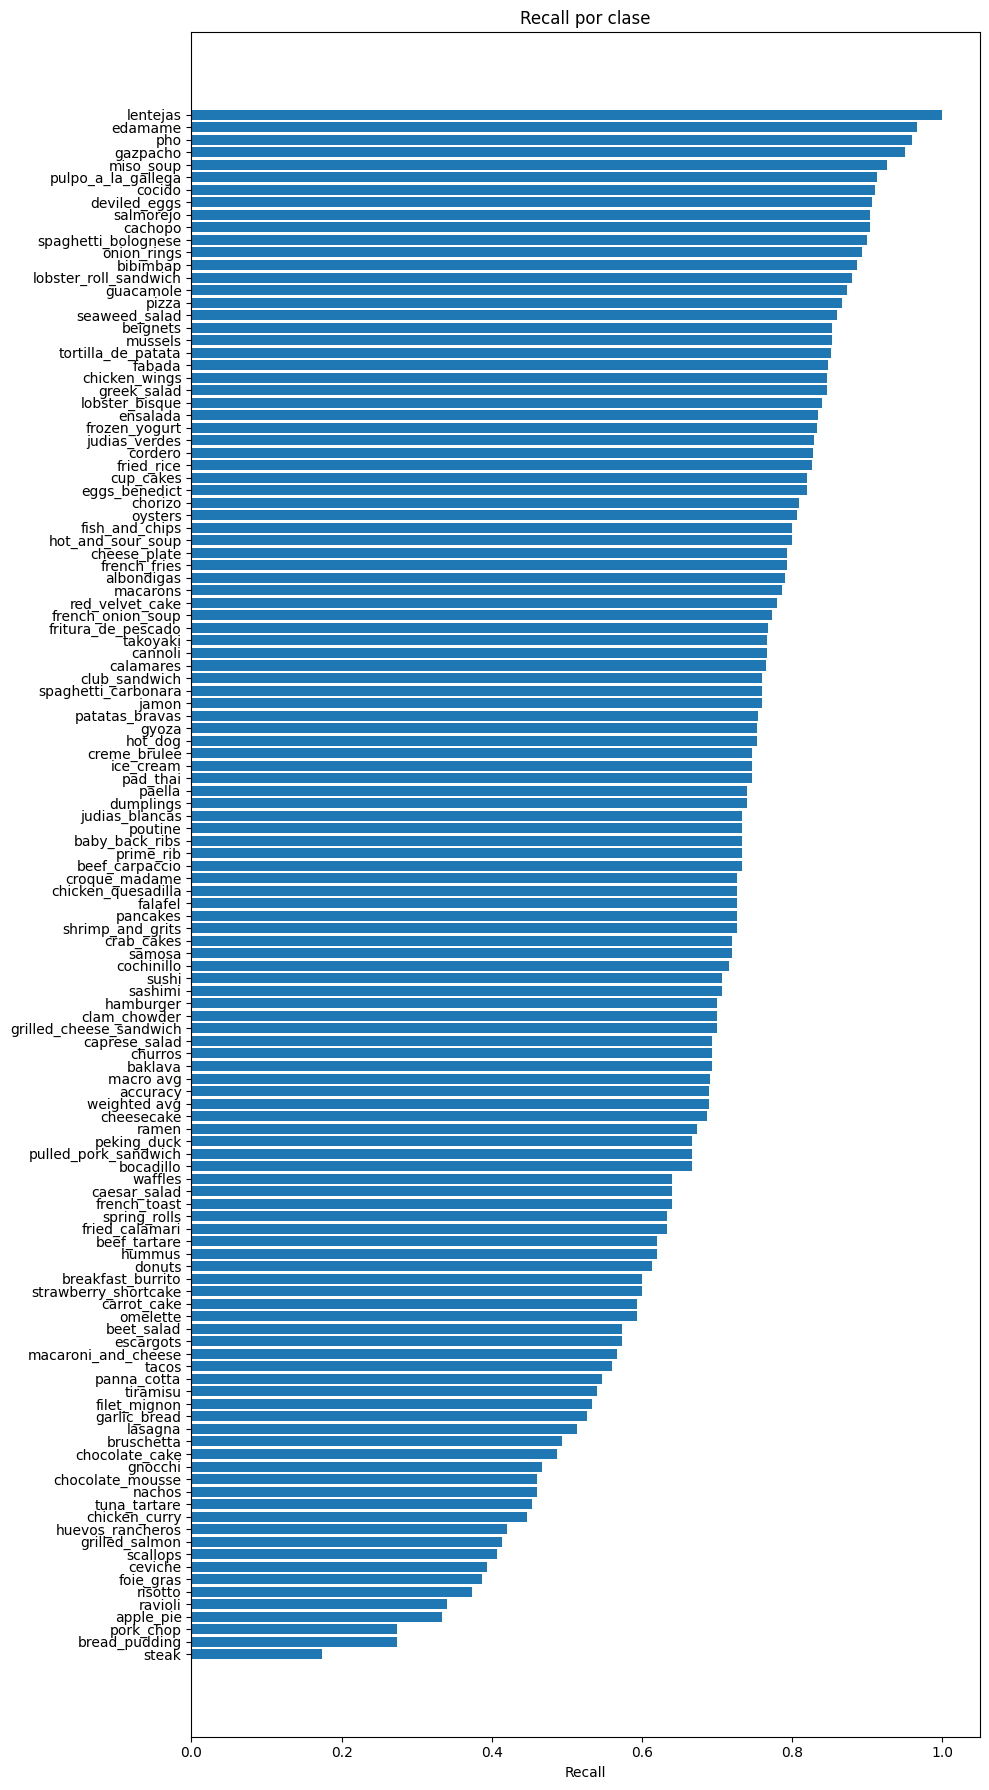

In [ ]:
from sklearn.metrics import classification_report

report_dict = classification_report(
    y_true,
    y_pred,
    target_names=classes,
    output_dict=True,
    zero_division=0
)

print(" report_dict creado")


plot_accuracy_per_class(report_dict)

# Conclusión

En este proyecto se ha desarrollado un sistema de Inteligencia Artificial basado en redes neuronales convolucionales capaz de analizar imágenes y clasificar su contenido de forma precisa mediante una arquitectura en cascada.

El uso de un clasificador binario inicial permite separar de manera efectiva imágenes de comida y no comida, mejorando la robustez del sistema y reduciendo errores en etapas posteriores. Posteriormente, los modelos especializados permiten identificar hasta **121 tipos de alimentos y 22 categorías de no-alimentos**, ofreciendo una interpretación visual más completa y fiable.

Los resultados obtenidos, evaluados mediante métricas como Top-1, Top-3 y Top-5 Accuracy, así como métricas por clase y matrices de confusión, demuestran que el sistema es capaz de generalizar correctamente y funcionar de manera adecuada en escenarios reales.

En conjunto, el sistema desarrollado es modular, escalable y fácilmente extensible, lo que lo convierte en una base sólida para futuras aplicaciones en análisis nutricional, clasificación automática de imágenes y sistemas inteligentes basados en visión por computador.